# Анализ результатов А/В - теста по внедрению улучшенной рекомендательной системы

**Цель:** Оценить результаты изменений, связанных с внедрением улучшенной рекомендательной системы; 

**Описание данных:**  
Имеется несколько датасетов:  
`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — данные о регистрациях пользователей с 7 до 21 декабря 2020 года.

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

**Техническое задание**

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.
    
**Ход исследования:**
1) [Загрузка и обзор данных](#first); <br>
2) [Предобработка данных](#second); <br>
3) [Оценка корректности проведения теста](#third): <br> 
   - [Проверка данных на соответствие ТЗ, приведение к соответствию](#tz);<br>
   - [Проверка пересечения аудитории с конкурирующим тестом](#two_tests);<br>
   - [Проверка пересечения времени проведения теста с маркетинговыми событиями](#m_events);<br>
   - [Проверка равномерности распределения по тестовым группам](#groups);<br>
   
4) [Исследовательский анализ](#fourth);<br>
5) [Анализ результатов А/В-теста](#fifth);<br>
6) [Общий вывод](#sixth).  

<a id='first'></a>
## Загрузка и обзор данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
from statsmodels.stats.proportion import proportions_ztest
from plotly import graph_objects as go

In [2]:
try:
    m_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
    users = pd.read_csv('/datasets/final_ab_new_users.csv')
    events = pd.read_csv('/datasets/final_ab_events.csv')
    participants = pd.read_csv('/datasets/final_ab_participants.csv')
except:
    m_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
    users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
    events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
    participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')

In [3]:
m_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [4]:
m_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [5]:
users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [7]:
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [8]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [9]:
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [10]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


Есть пропуски в таблице событий пользователей в столбце details. Даты храняться в формате object, необходимо привести их к соответствующему типу. 

<a id='second'></a>
## Предобработка данных

In [11]:
m_events['start_dt'] = pd.to_datetime(m_events['start_dt'])
m_events['finish_dt'] = pd.to_datetime(m_events['finish_dt'])

users['first_date'] = pd.to_datetime(users['first_date'])

events['event_dt'] = pd.to_datetime(events['event_dt'])

In [12]:
events['event_date'] = events['event_dt'].dt.normalize()

In [13]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
 4   event_date  440317 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(2)
memory usage: 16.8+ MB


### Анализ дубликатов

In [14]:
users['user_id'].duplicated().sum()

0

In [15]:
users['user_id'].str.lower().duplicated().sum()

0

In [16]:
users['region'].value_counts()

EU           46270
N.America     9155
CIS           3155
APAC          3153
Name: region, dtype: int64

In [17]:
users['device'].value_counts()

Android    27520
PC         15599
iPhone     12530
Mac         6084
Name: device, dtype: int64

In [18]:
events.duplicated().sum()

0

In [19]:
events['details'].value_counts()

4.99      46362
9.99       9530
99.99      5631
499.99     1217
Name: details, dtype: int64

In [20]:
events['event_name'].value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

In [21]:
participants['group'].value_counts()

A    9655
B    8613
Name: group, dtype: int64

In [22]:
participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

В таблице участников теста обнаружено 2 теста.

In [23]:
participants['user_id'].str.lower().duplicated().sum()

1602

Обнаружены дублирующиеся user_id в таблице участников тестов, значит возможно пользователи участвовали в обоих тестах или группах одновременно. 

In [24]:
(
    participants[participants['ab_test'] == 'recommender_system_test']['user_id']
    .str.lower().duplicated().sum()
)

0

Нет дублирующихся user_id в нашем тесте.

### Анализ пропусков

In [25]:
events.isna().mean()

user_id       0.000000
event_dt      0.000000
event_name    0.000000
details       0.857512
event_date    0.000000
dtype: float64

In [26]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
 4   event_date  440317 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(2)
memory usage: 16.8+ MB


В таблице событий 86% пропусков в столбце details, заполнено 62740 значений.

In [27]:
events[~events['details'].isna()]['event_name'].value_counts()

purchase    62740
Name: event_name, dtype: int64

Значения в столбце details заполнены только для событий purchase. Это полезная дополнительная информация, пропуски оставляем.

<a id='third'></a>
## Оценка корректности проведения теста

<a id='tz'></a>
### Проверка данных на соответствие ТЗ

Проверим данные на соответствие дат:
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04.

In [28]:
users_test = (
    participants[participants['ab_test'] == 'recommender_system_test']
    .merge(users, on='user_id')
)
users_test

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC
...,...,...,...,...,...,...
6696,053FB26D6D49EDDC,A,recommender_system_test,2020-12-10,N.America,Android
6697,9D263B8EF15CF188,B,recommender_system_test,2020-12-16,N.America,Mac
6698,F2FBBA33F37DEC46,A,recommender_system_test,2020-12-18,APAC,Mac
6699,29C92313A98B1176,B,recommender_system_test,2020-12-07,APAC,Android


In [29]:
print(users_test['first_date'].min(), users_test['first_date'].max())

2020-12-07 00:00:00 2020-12-21 00:00:00


Даты регистрации новых пользователей нашего теста соответствуют временному диапазону от запуска теста до остановки набора пользователей.

In [30]:
print(users['first_date'].min(), users['first_date'].max())

2020-12-07 00:00:00 2020-12-23 00:00:00


В таблице с данными о регистрации новых пользователей оставляем только пользователей, зарегистрировавшихся до даты остановки набора новых пользователей.  

In [31]:
users = users[users['first_date'] <= '2020-12-21']

In [32]:
print(events['event_dt'].min(), events['event_dt'].max())

2020-12-07 00:00:33 2020-12-30 23:36:33


Последняя дата событий 2020-12-30, а тест остановлен 2021-01-04. 

In [33]:
users_test['user_id'].nunique()

6701

Набрали в тест 6701 пользователей, соответствует требованию по количеству участников.

In [34]:
users_test['region'].value_counts(normalize=True)

EU           0.947769
N.America    0.033279
APAC         0.010745
CIS          0.008208
Name: region, dtype: float64

В тест попали 5% пользователей не из Европы. Удалим пользователей из других регионов.

In [35]:
users_notEU = users_test[users_test['region'] != "EU"]['user_id']

In [36]:
participants = participants[~participants['user_id'].isin(users_notEU)]

In [37]:
participants[participants['ab_test'] == 'recommender_system_test']['user_id'].count()

6351

In [38]:
users_test = users_test[users_test['region'] == 'EU']
users_test['user_id'].count()

6351

Осталось более 6000 пользователей, соответствует ТЗ.

In [39]:
(
    users_test[users_test['region'] == 'EU']['user_id'].count() / 
    users[users['region'] == 'EU']['user_id'].count() 
    * 100
)

15.0

Соответствует требованию: отобрано 15% новых пользователей из региона EU

<a id='two_tests'></a>
Проверим на пересечение участников 2х тестов:

In [40]:
ids_rs_test = set(participants[participants['ab_test'] == 'recommender_system_test']['user_id'])
ids_another_test = set(participants[participants['ab_test'] == 'interface_eu_test']['user_id'])

len(ids_rs_test & ids_another_test)

1602

In [41]:
len(ids_rs_test & ids_another_test) / len(ids_rs_test) * 100

25.22437411431271

1602 пользователя участвовали в обоих тестах, что составляет 25% участников нашего теста.

In [42]:
participants[
    (participants['ab_test'] == 'interface_eu_test') &
    (participants['user_id'].isin(ids_rs_test & ids_another_test))
     ]['group'].value_counts()

A    819
B    783
Name: group, dtype: int64

In [43]:
(
    participants[
        (participants['ab_test'] == 'interface_eu_test') &
        (participants['user_id'].isin(ids_rs_test & ids_another_test)) &
        (participants['group'] == 'B')
         ]['user_id'].count() / 
    participants[participants['ab_test'] == 'recommender_system_test']['user_id'].count()
)

0.1232876712328767

Оставляем участников нашего теста, которые попали в контрольную группу конкурирующего теста, поскольку на них не оказывалось никакого иного влияния.
Доля участников нашего теста, попавших в тестовую группу конкурирующего теста, составляет 12%. Теперь рассмотрим как они распределены по группам в нашем тесте.

In [44]:
ids_B = participants[
    (participants['ab_test'] == 'interface_eu_test') &
    (participants['user_id'].isin(ids_rs_test & ids_another_test)) &
    (participants['group'] == 'B')
     ]['user_id']

In [45]:
(
    participants[
        (participants['ab_test'] == 'recommender_system_test') &
        (participants['user_id'].isin(ids_B)) &
        (participants['group'] == 'A')
        ]['user_id'].count() / 
    participants[
        (participants['ab_test'] == 'recommender_system_test') & 
        (participants['group'] == 'A')
    ]['user_id'].count()
)

0.12080352228948817

In [46]:
(
    participants[
        (participants['ab_test'] == 'recommender_system_test') &
        (participants['user_id'].isin(ids_B)) &
        (participants['group'] == 'B')
        ]['user_id'].count() / 
    participants[
        (participants['ab_test'] == 'recommender_system_test') & 
        (participants['group'] == 'B')
    ]['user_id'].count()
)

0.12661023187338977

Участники нашего теста, попавшие в группу В конкурирующего теста, одинаково распределены по группам в нашем тесте. Можно допустить, что влияние этих пользователей одинаково в контрольной и тестовой группе, поэтому оставим их.

Проверим, что пользователи за 14 дней прошли воронку

In [47]:
users_test['user_id'].nunique()

6351

In [48]:
events[events['user_id'].isin(users_test['user_id'])]['user_id'].nunique()

3481

In [49]:
(
    events[events['user_id'].isin(users_test['user_id'])]['user_id'].nunique() / 
    users_test['user_id'].nunique()
)

0.548102660998268

Только 3481 (55%) участников теста совершали события. 

In [50]:
test = (
    events[events['user_id'].isin(users_test['user_id'])]
    .merge(users_test, on='user_id', how='outer')
)
test

,user_id,event_dt,event_name,details,event_date,group,ab_test,first_date,region,device
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,A,recommender_system_test,2020-12-07,EU,Android
1,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.99,2020-12-09,A,recommender_system_test,2020-12-07,EU,Android
2,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,NaN,2020-12-07,A,recommender_system_test,2020-12-07,EU,Android
3,831887FE7F2D6CBA,2020-12-08 10:52:27,product_cart,NaN,2020-12-08,A,recommender_system_test,2020-12-07,EU,Android
4,831887FE7F2D6CBA,2020-12-09 02:19:17,product_cart,NaN,2020-12-09,A,recommender_system_test,2020-12-07,EU,Android
...,...,...,...,...,...,...,...,...,...,...
26285,C5E1BD2400840B30,NaT,NaN,NaN,NaT,B,recommender_system_test,2020-12-17,EU,iPhone
26286,EA29547AB3C0CB9C,NaT,NaN,NaN,NaT,B,recommender_system_test,2020-12-14,EU,iPhone
26287,9A44E27079666291,NaT,NaN,NaN,NaT,B,recommender_system_test,2020-12-08,EU,Android
26288,9C2D0067A991213E,NaT,NaN,NaN,NaT,B,recommender_system_test,2020-12-07,EU,PC


In [51]:
test['first_event'] = (test['event_date'] - test['first_date']).dt.days

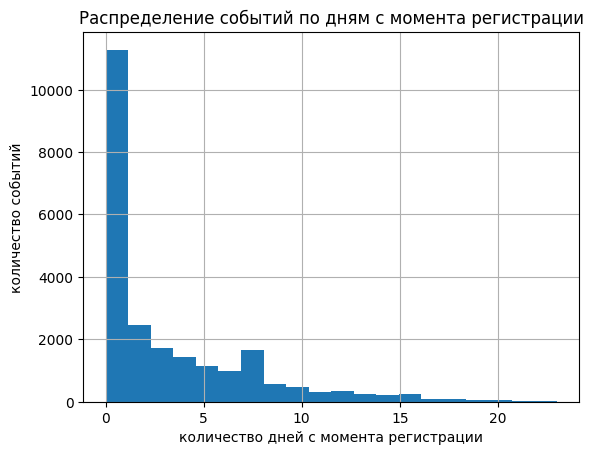

In [52]:
plt.figure()
test['first_event'].hist(bins=20)
plt.xlabel('количество дней с момента регистрации')
plt.ylabel('количество событий')
plt.title('Распределение событий по дням с момента регистрации');

В основном пользователи совершают события в первые дни после регистрации.

In [53]:
test = test[
    (test['event_date'].isna()) | 
    (test['event_date'] <= (test['first_date'] + timedelta(days=14)))
]

Удалили события, происходящие позже чем через 14 дней после регистрации

In [54]:
len(test)

25698

In [55]:
test['user_id'].nunique()

6351

<a id='m_events'></a>
### Проверка совпадения времени проведения теста с маркетинговыми событиями

In [56]:
m_events['start_test'] = datetime.datetime(2020, 12, 7)
m_events['end_test'] = datetime.datetime(2021, 1, 4)

m_events

,name,regions,start_dt,finish_dt,start_test,end_test
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,2020-12-07,2021-01-04
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16,2020-12-07,2021-01-04
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19,2020-12-07,2021-01-04
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19,2020-12-07,2021-01-04
4,4th of July Promo,N.America,2020-07-04,2020-07-11,2020-12-07,2021-01-04
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01,2020-12-07,2021-01-04
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07,2020-12-07,2021-01-04
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03,2020-12-07,2021-01-04
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10,2020-12-07,2021-01-04
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11,2020-12-07,2021-01-04


События, начавшиеся до периода и закончившиеся во время проведения теста:

In [57]:
m_events.query('start_dt < start_test and finish_dt >= start_test and finish_dt <= end_test')

,name,regions,start_dt,finish_dt,start_test,end_test


События, начавшиеся до периода и закончившиеся после проведения теста:

In [58]:
m_events.query('start_dt < start_test and finish_dt > end_test')

,name,regions,start_dt,finish_dt,start_test,end_test


События, начавшиеся и закончившиеся во время проведения теста:

In [59]:
m_events.query(
    'start_dt >= start_test and start_dt <= end_test and finish_dt >= start_test and finish_dt <= end_test'
)

,name,regions,start_dt,finish_dt,start_test,end_test
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,2020-12-07,2021-01-04


События, начавшиеся во время и закончившиеся после проведения теста:

In [60]:
m_events.query('start_dt >= start_test and start_dt <= end_test and finish_dt > end_test')

,name,regions,start_dt,finish_dt,start_test,end_test
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07,2020-12-07,2021-01-04


Последнее событие не проводилось в Европе, поэтому его не учитываем. Итого во время проведения теста происходило одно событие. Посмотрим на распределение пользовательских событий по датам:

In [61]:
test['event_date'].max() - test['event_date'].min()

Timedelta('22 days 00:00:00')

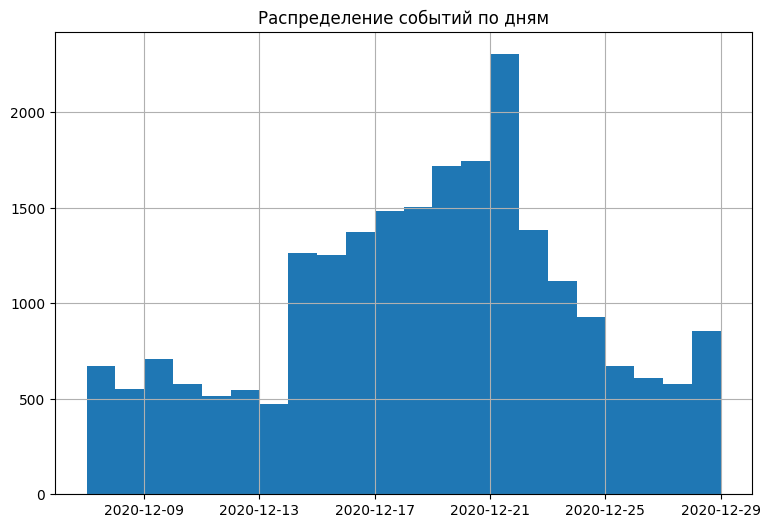

In [62]:
test['event_date'].hist(figsize=(9,6), bins=22)
plt.title('Распределение событий по дням');

Маркетинговое событие не влияет на количество пользовательских событий. Увеличение количества событий до 21 декабря вероятно связано с увеличением количества новых пользователей, поскольку до этой даты совершался набор.

<a id='groups'></a>
### Проверка распределения участников теста по группам

In [63]:
len(
    set(users_test[users_test['group'] == 'A']['user_id']) &
    set(users_test[users_test['group'] == 'B']['user_id'])
)

0

Нет участников, попавших в обе группы.

In [64]:
users_test['group'].value_counts(normalize=True)

A    0.572193
B    0.427807
Name: group, dtype: float64

57% участников относятся к контрольной группе, 43% - к тестовой.

In [65]:
alpha = 0.05
count = np.array([
    users_test[users_test['group'] == 'A']['user_id'].count(), 
    users_test[users_test['group'] == 'B']['user_id'].count()
])
nobs = users_test['user_id'].count()
st, p_value = proportions_ztest(count, nobs)

print('p-value', p_value)
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть статистически значимая разница')
else:
    print('Не удалось отвергнуть нулевую гипотезу: нет оснований считать доли разными')

p-value 1.5386058814776924e-59
Отвергаем нулевую гипотезу: между долями есть статистически значимая разница


Количество участников между группами распределено неравномерно. 

<a id='fourth'></a>
## Исследовательский анализ

### Изучение аудитории теста по группам

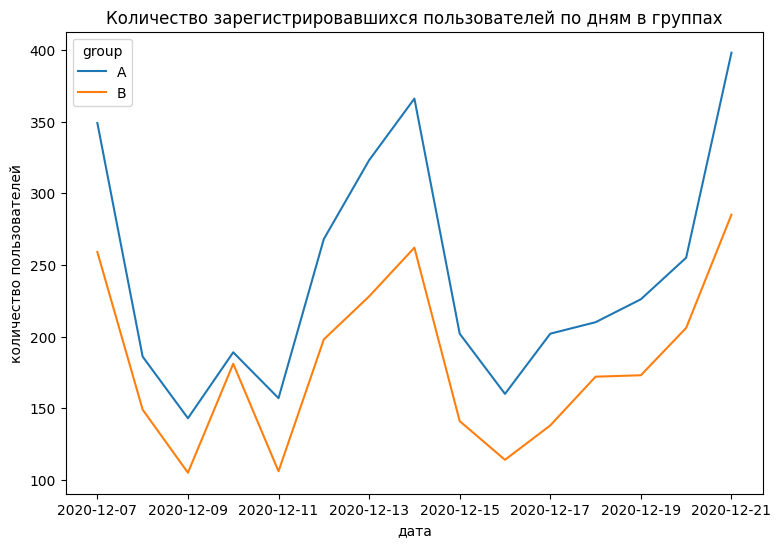

In [66]:
plt.figure(figsize=(9,6))
sns.lineplot(
    data=test.groupby(['first_date', 'group'], as_index=False)['user_id'].nunique(),
    x='first_date',
    y='user_id',
    hue='group'
)
plt.title('Количество зарегистрировавшихся пользователей по дням в группах')
plt.ylabel('количество пользователей')
plt.xlabel('дата');

Участники групп А и В регистрировались по дням одинаково. Максимум регистраций пришелся на первый, последний дни и 14 декабря.

In [67]:
test.groupby(['group', 'device'], as_index=False)['user_id'].nunique()

,group,device,user_id
0,A,Android,1590
1,A,Mac,354
2,A,PC,964
3,A,iPhone,726
4,B,Android,1228
5,B,Mac,250
6,B,PC,657
7,B,iPhone,582


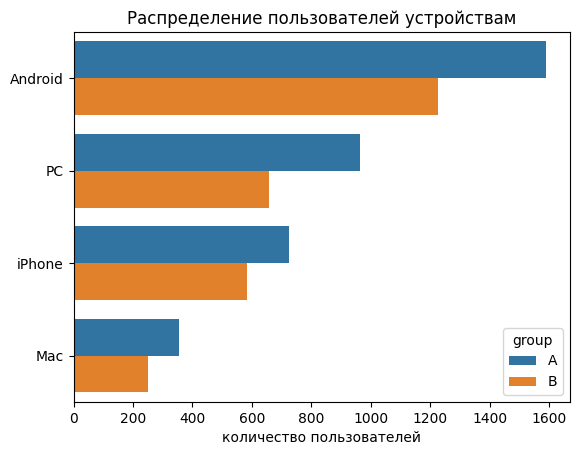

In [68]:
plt.figure()
sns.barplot(
    data=(
        test.groupby(['group', 'device'], as_index=False)['user_id'].nunique()
        .sort_values('user_id', ascending=False)
    ), 
    x='user_id', 
    y='device', 
    hue='group'
)
plt.title('Распределение пользователей устройствам')
plt.ylabel('')
plt.xlabel('количество пользователей');

Участники группы А и В одинаково распределены по устройствам, с которых они регистрировались. Больше всего пользователей регистрировались с Android.

In [69]:
test.dropna(subset=['event_name']).groupby(['event_name','group'], as_index=False)['user_id'].nunique()

,event_name,group,user_id
0,login,A,2604
1,login,B,876
2,product_cart,A,782
3,product_cart,B,244
4,product_page,A,1685
5,product_page,B,493
6,purchase,A,833
7,purchase,B,249


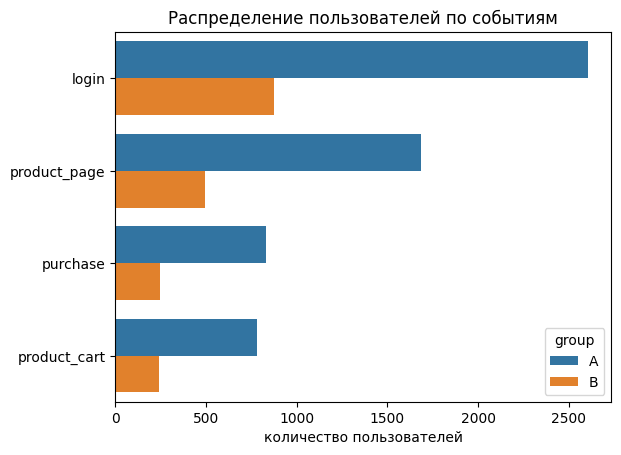

In [70]:
plt.figure()
sns.barplot(
    data=(
        test.dropna(subset=['event_name'])
        .groupby(['event_name','group'], as_index=False)['user_id'].nunique()
        .sort_values('user_id', ascending=False)
    ),
    x='user_id',
    y='event_name',
    hue='group'
)
plt.title('Распределение пользователей по событиям')
plt.ylabel('')
plt.xlabel('количество пользователей');

Распределение пользователей групп А и В по событиям одинаково.

In [71]:
test.dropna(subset=['details']).groupby(['details','group'], as_index=False)['user_id'].count()

,details,group,user_id
0,4.99,A,1858
1,4.99,B,469
2,9.99,A,374
3,9.99,B,93
4,99.99,A,222
5,99.99,B,50
6,499.99,A,45
7,499.99,B,12


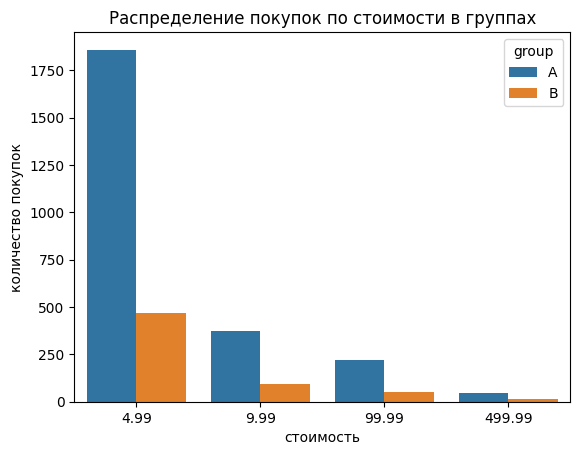

In [72]:
plt.figure()
sns.barplot(
    data=test.dropna(subset=['details']).groupby(['details','group'], as_index=False)['user_id'].count(),
    x='details',
    y='user_id',
    hue='group'
)
plt.title('Распределение покупок по стоимости в группах')
plt.ylabel('количество покупок')
plt.xlabel('стоимость');

Распределение стоимости покупок в группах одинаково.

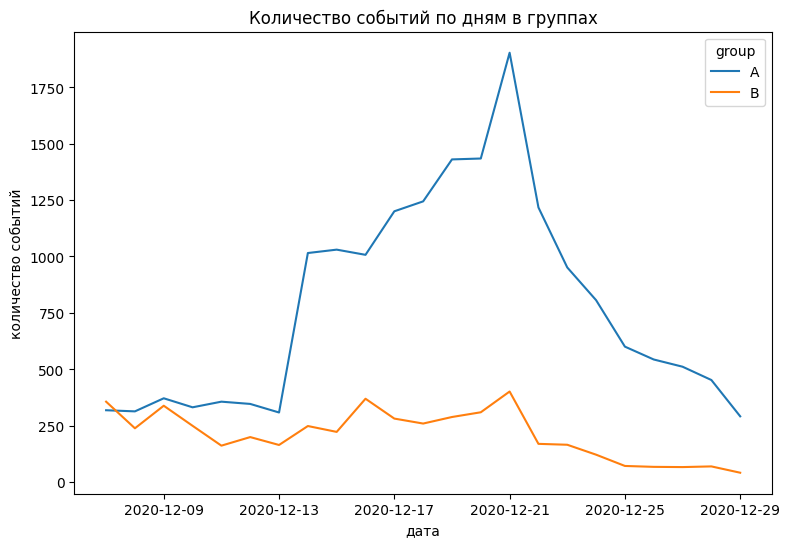

In [73]:
plt.figure(figsize=(9,6))
sns.lineplot(
    data=(
        test.dropna(subset=['event_name'])
        .groupby(['event_date','group'], as_index=False)['user_id'].count()
    ),
    x='event_date',
    y='user_id',
    hue='group'
)
plt.title('Количество событий по дням в группах')
plt.ylabel('количество событий')
plt.xlabel('дата');

В группе А количество событий резко возросло с 2020-12-13, снижалось с 2020-12-21. В эти дни было максимальное количество регистраций. В группе В количество событий менялось незначительно в разные дни, к концу периода снижалось, как и в группе А.

In [74]:
events_by_day = (
    test.dropna(subset=['event_name'])
    .groupby(['event_date','group'], as_index=False)['user_id'].agg(['count', 'nunique'])
)
events_by_day['events_per_user'] = events_by_day['count'] / events_by_day['nunique']

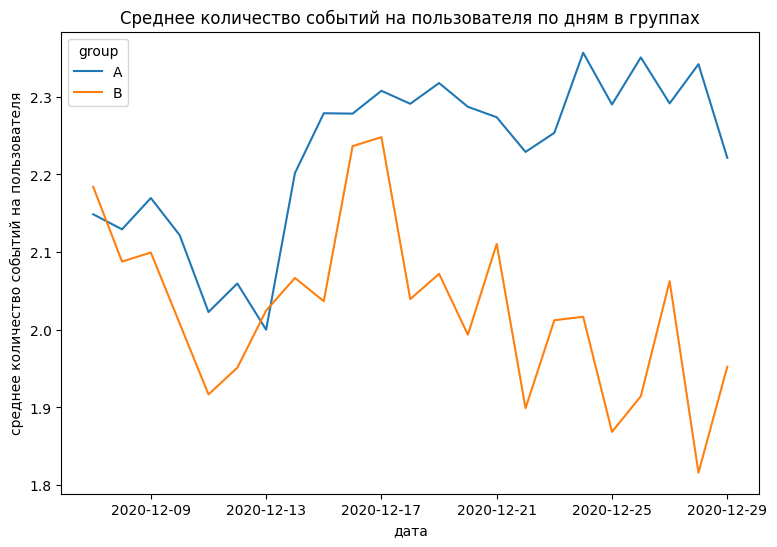

In [75]:
plt.figure(figsize=(9,6))
sns.lineplot(
    data=events_by_day,
    x='event_date',
    y='events_per_user',
    hue='group'
)
plt.title('Среднее количество событий на пользователя по дням в группах')
plt.ylabel('среднее количество событий на пользователя')
plt.xlabel('дата');

С середины периода проведения теста разница между количеством событий в группах становится больше.

### Распределение количества событий на пользователя в выборках

Ранее уже определили, что не все пользователи совершали события, а только 3481 (55%) участников. Посмотрим в разрезе групп как распределены количества событий на пользователя.

In [76]:
test.dropna(subset=['event_name'])['group'].value_counts(normalize=True)

A    0.787498
B    0.212502
Name: group, dtype: float64

79% событий приходится на группу А, 21% событий на группу В.

In [77]:
test.dropna(subset=['event_name']).groupby('group')['user_id'].nunique()

group
A    2604
B     877
Name: user_id, dtype: int64

In [78]:
(
    test.dropna(subset=['event_name']).groupby('group')['user_id'].nunique() /
    test.dropna(subset=['event_name'])['user_id'].nunique()
)

group
A    0.748061
B    0.251939
Name: user_id, dtype: float64

In [79]:
test.dropna(subset=['event_name']).groupby('group')['user_id'].nunique() / users_test['group'].value_counts()

group
A    0.716566
B    0.322782
dtype: float64

Из всех пользователей, совершавших события, 75% из группы А, 25% из группы В.  
Из всех пользователей группы А 72% совершали события, из группы В совершали события 32% пользователей.

In [80]:
events_per_user = (
    test.dropna(subset=['event_name'])
    .groupby(['user_id', 'group'], as_index=False)['event_name'].count()
)

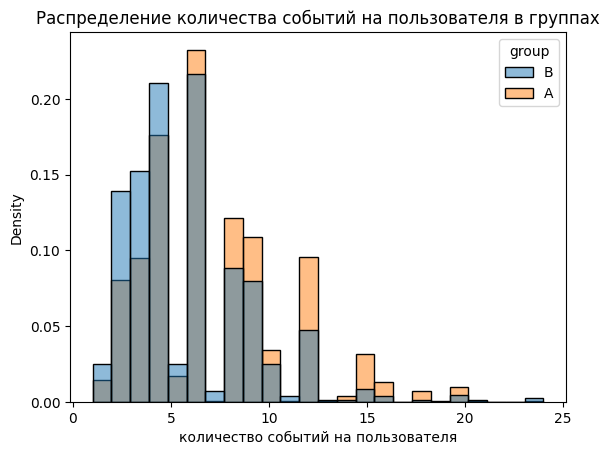

In [81]:
plt.figure()
sns.histplot(
    data=events_per_user,
    x='event_name',
    hue='group',
    stat='density', common_norm=False,
    bins=24

)
plt.title('Распределение количества событий на пользователя в группах')
plt.xlabel('количество событий на пользователя');

В группе В на пользователя приходится меньше событий, чем в группе А. 

In [82]:
events_per_user.query('group == "A"')['event_name'].median()

6.0

In [83]:
events_per_user.query('group == "B"')['event_name'].median()

4.0

In [84]:
test.query('group == "A"').groupby('user_id')['event_name'].count().median()

4.0

In [85]:
test.query('group == "B"').groupby('user_id')['event_name'].count().median()

0.0

В среднем на пользователя (только среди пользователей, совершавших события) приходится 6 событий в группе А и 4 события в группе В.

Среди всех пользователей группы А в среднем на одного приходится 4 события, пользователи группы В в среднем не совершают ни одного события.

### Воронка событий

In [86]:
funnel = (
    test.dropna(subset=['event_name'])
    .pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique')
)
funnel = funnel.reindex(['login', 'product_page', 'product_cart', 'purchase'])
funnel

group,A,B
event_name,,
login,2604,876
product_page,1685,493
product_cart,782,244
purchase,833,249


In [87]:
funnel['conv_A'] = funnel['A'].div(funnel.loc['login', 'A']).round(3)
funnel['conv_B'] = funnel['B'].div(funnel.loc['login', 'B']).round(3)

In [88]:
funnel

group,A,B,conv_A,conv_B
event_name,,,,
login,2604,876,1.000,1.000
product_page,1685,493,0.647,0.563
product_cart,782,244,0.300,0.279
purchase,833,249,0.320,0.284


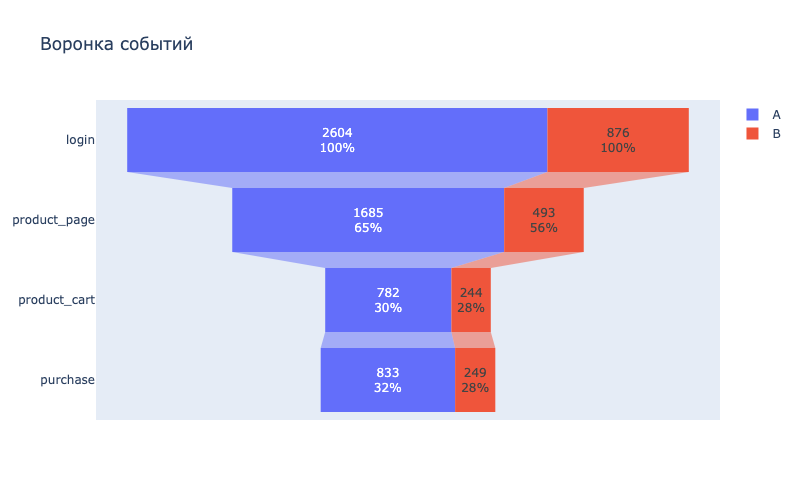

In [89]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name='A',
    y=funnel.index, 
    x=funnel['A'], 
    textposition = "inside",
    textinfo = "value+percent initial")
    )

fig.add_trace(go.Funnel(
    name='B',
    y=funnel.index, 
    x=funnel['B'], 
    textposition = "inside",
    textinfo = "value+percent initial")
    )

fig.update_layout(title='Воронка событий', height=500, width=800)
fig.show('png')

В контрольной группе конверсия в просмотр страницы товара - 65%, конверсия в просмотр корзины - 30%, конверсия в покупку - 32%. 
В тестовой группе конверсия в просмотр страницы товара - 56%, конверсия в просмотр корзины - 28%, конверсия в покупку - 28%. 
Метрики ни на одном из этапов не улучшились. 

**Факторы, которые могут негативно влиять на точность теста:**
- Нет данных о пользовательских событиях за последние 5 дней проведения теста. Последняя дата событий 30 декабря, а тест остановлен 4 января.
- Одновременно проводилось 2 теста, участники попали в оба теста.
- Участники между группами распределены неравномерно. В группу А попало больше пользователей. Кроме того в группе А пользователи были более активными. 

<a id='fifth'></a>
## Оценка результатов А/В-теста

Ожидаемый эффект не был достигнут: метрики не улучшились. Наоборот по сравнению с контрольной группой конверсия на всех этапах несколько снизилась. Нужно оценить является ли это статистически значимой разницей.

###  Расчет статистической значимости

Н0 - Конверсия в группах А и В равна.  
Н1 - Конверсия в группах А и В отличается. 

Так как проводятся множественные сравнения, для уровня статистической значимости используем поправку Бонферрони. 

In [90]:
alpha = 0.05 / 3

for stage in ['product_page', 'product_cart', 'purchase']:
    count = np.array([
        funnel.loc[stage, 'A'], 
        funnel.loc[stage, 'B']
    ])
    nobs = np.array([
        funnel.loc['login', 'A'],
        funnel.loc['login', 'B']
    ])
                 
    st, p_value = proportions_ztest(count, nobs)
    print(count, nobs)
    
    print(f'Сравнение конверсий в {stage}')
    print('p-value', p_value)
    if p_value < alpha:
        print(f'Отвергаем нулевую гипотезу: есть статистически значимая разница в конверсии')
    else:
        print(f'Не удалось отвергнуть нулевую гипотезу: нет оснований считать конверсии разными')
    print('---' * 20)

[1685  493] [2604  876]
Сравнение конверсий в product_page
p-value 8.195976000351998e-06
Отвергаем нулевую гипотезу: есть статистически значимая разница в конверсии
------------------------------------------------------------
[782 244] [2604  876]
Сравнение конверсий в product_cart
p-value 0.2215941567364419
Не удалось отвергнуть нулевую гипотезу: нет оснований считать конверсии разными
------------------------------------------------------------
[833 249] [2604  876]
Сравнение конверсий в purchase
p-value 0.0486476669504243
Не удалось отвергнуть нулевую гипотезу: нет оснований считать конверсии разными
------------------------------------------------------------


Итак, конверсия в просмотр страницы товара в тестовой группе снизилась по сравнению с контрольной. Конверсии остальных этапов между группами не отличаются.

<a id='sixth'></a>
## Общий вывод

Были изучены 4 таблицы данных. Дубликатов не обнаружено, определена причина пропусков. Даты приведены к соответствующему формату.   
Данные были проверены на соответствие ТЗ:
- даты регистрации участников теста соответствуют периоду набора в тест;
- количество участников 6351;  
- для участия отобрано 15% пользователей из Европы;

Данные приведены в соответствие ТЗ:  
- исключены участники теста не из Европы; 
- исключены события выходящие за пределы 14 дней с момента регистрации.  

Было обнаружено, что   
- Нет данных о пользовательских событиях за последние 5 дней проведения теста. Последняя дата событий 30 декабря, а тест остановлен 4 января.  
- Проводилось 2 теста одновременно и значительная часть пользователей участвовали в двух тестах. При этом участники нашего теста, попавшие в группу В конкурирующего теста, одинаково распределены по группам в нашем тесте.   
- Только 55% участников теста совершали события.  
- Одно маркетинговое событие попало на период проведения теста. 

Проверено распределение пользователей по группам. Пользователи по группам не пересекаются. Количество участников распределено неравномерно. 57% участников относятся к контрольной группе, 43% - к тестовой.  
В целом поведение пользователей двух групп схоже, за исключением активности. В группе А пользователи совершали больше событий, чем в группе В. Из всех пользователей, совершавших события, 75% из группы А, 25% из группы В; в среднем на пользователя приходится 6 событий в группе А и 4 события в группе В. Среди всех пользователей группы А в среднем на одного приходится 4 события, медианное количество событий на пользователя группы В - 0.

Построена воронка событий, посчитана конверсия на каждом шаге. В контрольной группе конверсия в просмотр страницы товара - 65%, конверсия в просмотр корзины - 30%, конверсия в покупку - 32%. В тестовой группе конверсия в просмотр страницы товара - 56%, конверсия в просмотр корзины - 28%, конверсия в покупку - 28%. 

Ожидаемый эффект не был достигнут: метрики не улучшились. Оценена статистическая значимость изменения конверсии. Конверсия в просмотр страницы товара снизилась, а конверсии в просмотр корзины и в покупку не изменились. 

Негативно повлиять на точность теста могли следующие факторы:   
- Отсутствие данных о пользовательских событиях за последние 5 дней проведения теста; 
- Одновременное проведение 2 тестов; 
- Проведение теста в предпраздничные дни.

Рекомендуется провести тест заново, поскольку тест остановлен на 5 дней раньше, не исключена "проблема подглядывания".